![Header Image](../assets/header_image.png "Header Image")

# Assignment 4: Boosting Semantic Point Cloud Segmentation Solution

In this assignment, we will consider the topic __semantic point cloud segmentation__. It's very similar to semantic image segmentation, because we will use a 2D matrix representation of a point cloud in order to process it with the same approach than in __semantic image segmentation__.

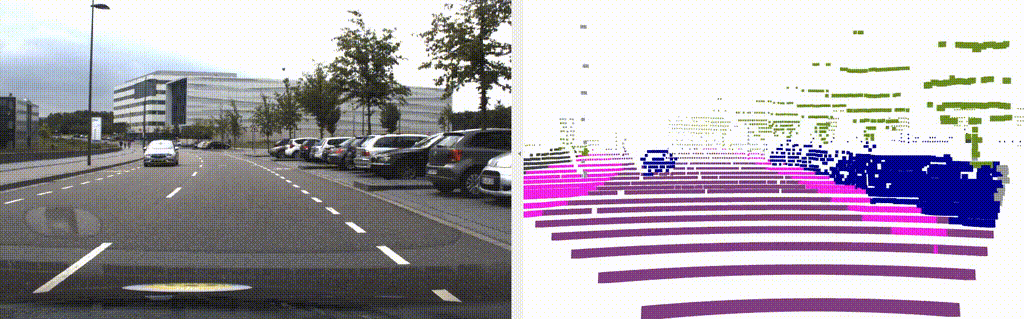

In this assignment we will walk through following steps:

- Implement an augmentation function for flipping the LiDAR point cloud
- Implement an augmentation fucntion for shifting the LiDAR point cloud
- Implement an improved loss function for the model, the __focal loss__

Let's start by importing all the necessary imports for this assignment:

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import scipy
import random
import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from easydict import EasyDict

import plotly.graph_objects as go


tf.random.set_seed(42)
random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

Let's import the functions `segmentation_map_to_rgb_encoding` and `fix_shape` from the previous assignment.

In [2]:
from pcl_segmentation_boosting_utils import segmentation_map_to_rgb_encoding

## Dataset Loading

Our labeled dataset for this assignment can be found in the directory `datasets/pcl_segmentation`. This dataset contains already a `training` and `validation` split. Each sample is a numpy `*.npy` which is the native format to store numpy ndarrays. Furthermore, each sample contains the input data and the corresponding label.

In [3]:
# relative pathes to the datasets
train_path = "datasets/pcl_segmentation/train"
val_path = "datasets/pcl_segmentation/val"

# get all file pathes
train_pathes = sorted(glob.glob(os.path.join(train_path, "*.npy")))
val_pathes = sorted(glob.glob(os.path.join(val_path, "*.npy")))

In [4]:
print("Number of training samples: ", len(train_pathes))
print("Number of validation samples: ", len(val_pathes))

Number of training samples:  200
Number of validation samples:  50


## Configuration 
We will use the same configurations as in the previous assingment:

In [5]:
cfg = EasyDict()

# Class name definitions
cfg.CLASSES = ['Road',
              'Sidewalk',
              'Building',
              'Pole',
              'Vegetation',
              'Person',
              'TwoWheeler',
              'Car',
              'Truck',
              'Bus',
              'None']

cfg.NUM_CLASS = len(cfg.CLASSES)

# Color class association
# e.g. Index 0 corresponds to color [128, 64, 128] and class 'Road'
cfg.CLS_COLOR_MAP = np.array([[128,  64,  128],  # Road
                              [244,  35,  232],  # Sidewalk
                              [70,   70,   70],  # Building
                              [153, 153,  153],  # Pole
                              [107, 142,   35],  # Vegetation
                              [220,  20,   60],  # Person
                              [255,   0,    0],  # Two Wheeler
                              [0,     0,  142],  # Car
                              [0,     0,   70],  # Truck
                              [0,    60,  100],  # Bus
                              [0,     0,    0]   # None
                              ]) / 255.0

# Input Shape
cfg.AZIMUTH_LEVEL = 240
cfg.ZENITH_LEVEL = 32
cfg.NUM_FEATURES = 6
cfg.BATCH_SIZE = 4

# x, y, z, intensity, distance
cfg.INPUT_MEAN = np.array([[[24.810, 0.819, 0.000, 16.303, 25.436]]])
cfg.INPUT_STD =  np.array([[[30.335, 7.807, 2.058, 25.208, 30.897]]])

Note, that we are using the `EasyDict` instance `cfg` throughout the whole assignment. It allows us to store and access various variables quite easily. 

# 2D Plot of the Label

Let's get startet and load a sample from the dataset:

In [6]:
sample = np.load(train_pathes[0])
print("Sample shape:", sample.shape)

Sample shape: (32, 240, 6)


You will have probably noticed that the left and right boundaries of the 2D point cloud are __not labelled__. This is caused by the automatic labelling approach. Only LiDAR points that are visible in the Field Of View of the camera could be automaticall annotated. In this assignment, we will implement some __augmentation techniques__ to deal with this problem.

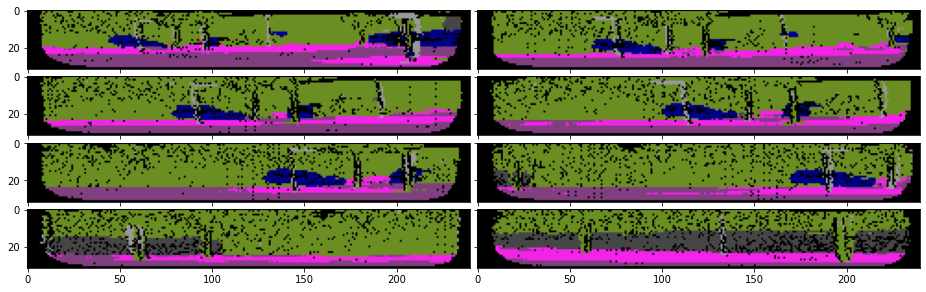

In [7]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i, ax in enumerate(grid):
    sample = np.load(train_pathes[i*6])
    segmentation_map = sample[:, :, 5]
    rgb_encoding = segmentation_map_to_rgb_encoding(segmentation_map, cfg.CLS_COLOR_MAP)
    ax.imshow(rgb_encoding)

# Data Augmentation and Dataset Pipeline

We will now build a Tensorflow pipeline similar to the previous assignment, but we will add some __augmentation functions__ to the pipeline to increase the robustness of the trained model. These augmentation functions focus only on geometrical shifts of the input. That means we won't apply typical __image augmentation__ functions. 

We will consider the fact that the LiDAR point cloud is a rotating sensor and that only a part of the input tensor is labeled. We can leverage this issue by flipping and shifting the input representation to make the trained model robust against any horizontal variations outside of the training set distribution.   

# Task: Random Flip Augmentation

Perform a random flip on the y-axis on a given sample with shape `[height, width, channels]`. The shape in our case is `[32, 240, 6]`

#### Replace the `None` placeholders with your code

Note that we will use only Numpy function here. Not Tensorflow.

### Hints
- Use `np.random.rand()` to draw samples from a uniform distribution over `[0, 1)`
- Compare the random number with `prob`. If the random number is smaller or equal than `prob`, then perform the flip
- Use numpys `np.fliplr()` function to flip the tensor


In [8]:
def random_y_flip(sample, prob=0.5):
    """
    Randomply flips a Numpy ndArray along the second axis (y-axis) with probability prob
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    prob -- Float which describes the probability that the flip is applied on the sample.
    
    Returns:
    sample -- Numpy ndArray of shape [height, width, channels] probably flipped on the 2nd axis
    """
    
    ### START CODE HERE ###
    
    if np.random.rand() <= prob:  # if None > None:
        sample = np.fliplr(sample)  #  sample = None
    
    ### END CODE HERE ###
    
    return sample

### Test `random_y_flip` 
Run the following cell and compare the output with the expected output. The outputs should be identical if your implementation is correct.

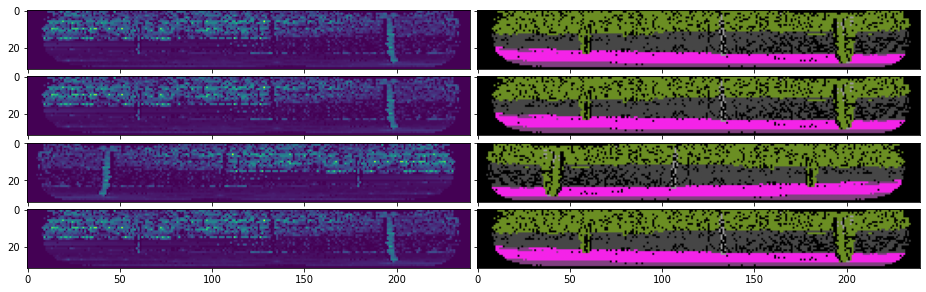

In [9]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 4*2, 2):
    sample_flipped = random_y_flip(sample)
    rgb_encoding = segmentation_map_to_rgb_encoding(sample_flipped[:, :, 5], cfg.CLS_COLOR_MAP)
    
    grid[i].imshow(sample_flipped[:, :, 3])
    grid[i+1].imshow(rgb_encoding)

### Expected Output

You should see that some samples are flipped on the 2nd dimension. You may run the above cell several times to see the effect. 

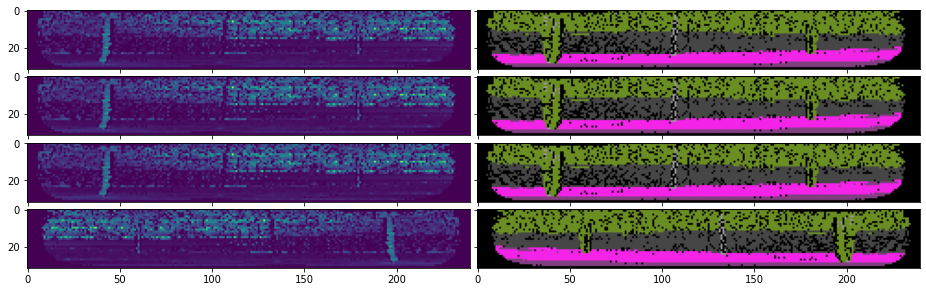

# Task: Random Shift Augmentation

Perform a random shift on the y-axis on a given sample with shape `[height, width, channels]`. The shape in our case is `[32, 240, 6]`. This augmentation function is intended to make the model more robust in terms of horizontal variations of the LiDAR point cloud. 

#### Replace the `None` placeholders with your code

Note that we will use only numpy functions here. Not the Tensorflow API.

### Hints
- Generate a random single integer using [np.random.randint()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html). Use a lower bound of `-shift` and a upper bound of `shift`. This random integer will be stored in `random_y_shift` and defines by how much the tensor is shifted on the 2nd axis
- Read the documentation of [scipy.ndimage.shift()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html). We will use this function for shifting the tensor representation. 
- The shift should only be performed on the 2nd axis. The values of this shift corresponds to `random_y_shift`. There is no shift to the other dimensions.
- Set the `mode` to `wrap`. But you can also play with other modes and see their effect on the tensor.

In [10]:
def random_shift(sample, shift=75):
    """
    Randomly shifts a sample on the y-axis
    
    Arguments:
    sample -- Numpy ndArray of shape [height, width, channels]
    shift -- Integer which defines the maximal amount of the random horizontal shift
    
    Returns :
    sample -- Numpy ndArray of shape [height, width, channels]
    """
    
    ### START CODE HERE ###
    
    # Generate a random integer between in [-shift, shift]
    random_y_shift = np.random.randint(low=-shift, high=shift)  # random_y_shift = None
    
    # Perform the shift on the sample
    sample = scipy.ndimage.shift(input=sample,
                                 shift=[0, random_y_shift, 0],
                                 order=0,
                                 mode='wrap')    
    
    # sample = scipy.ndimage.shift(input=None,
    #                              shift=[None, None, None], )
    #                              order=0,
    #                              mode=None)
    
    ### END CODE HERE ###
    
    return sample

### Test `random_shift`
Run the following cell and compare the output with the expected output. The outputs should be identical if your implementation is correct.

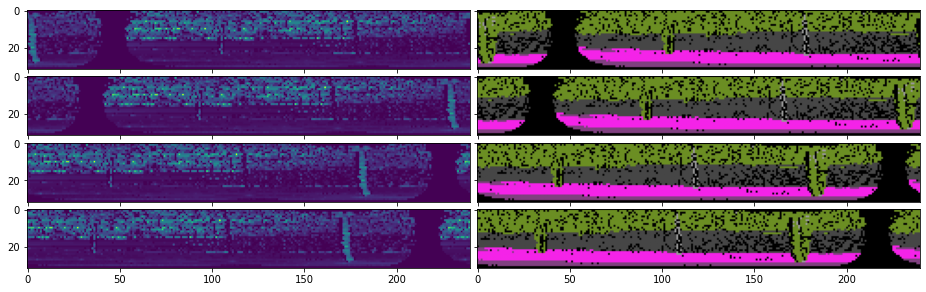

In [11]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 4*2, 2):
    sample_shifted = random_shift(sample)
    rgb_encoding = segmentation_map_to_rgb_encoding(sample_shifted[:, :, 5], cfg.CLS_COLOR_MAP)
    
    grid[i].imshow(sample_shifted[:, :, 3])
    grid[i+1].imshow(rgb_encoding)

### Expected Output

Great! We are able to randomly shift the input label pair on the horizontal axis. In doing so, we can assure that the model is also able to perform the segmentation task on the areas which were not labelled in the original dataset. We can also assume that the model get more robust in terms of the spatial location of the features.

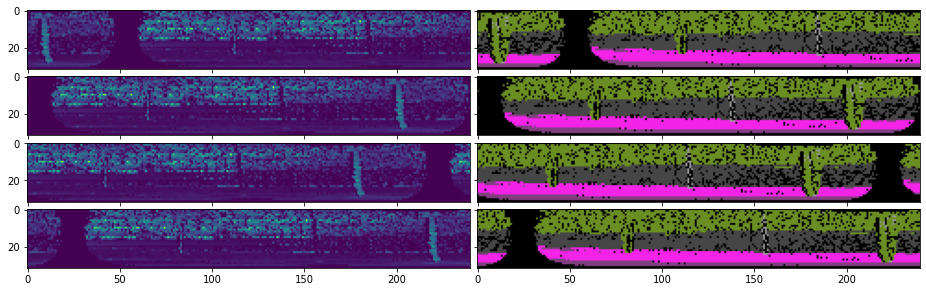

## Task: Implement `parse_sample` with augmentation

In this task you will complete the `parse_sample` function which will read a sample and applies the augmentations functions.  It returns the augmented `lidar` input data and the corresponding augmented boolean `mask` and the segmentation map `label`.

As we have only two augmentation functions, we won't use an augmentation policy. We will just use `random_y_flip()` and `random_shift()` with default parameters in sequence. 

#### Replace the `None` placeholders with your code


### Hints
- Apply `random_y_flip()` to sample
- Apply `random_shift()` on the output of the previous augmentation
- Use the default params for both methods

In [12]:
def parse_sample(sample_path, do_augmentation=True):
    """
    Parses a data sample from a file path an returns a lidar tensor, a mask tensor and a label tensor
    
    Arguments:
    sample_path -- String - File path to a samle .npy file
    do_augmentation -- Boolean which defines if the augmentation should be applied or not
    
    Returns:
    lidar -- numpy ndarray of shape [height, width, 5] containing the normalized lidar data
    mask -- numpy ndarray of shape  [height, width] containing a boolean mask
    label -- numpy ndarray of shape [height, width] containing the label as segmentation map
    """
    
    # Load numpy sample
    sample = np.load(sample_path.numpy()).astype(np.float32, copy=False)
    
    # Get original shape
    original_shape = np.shape(sample) 
    
    
    ### START CODE HERE ### 
    if do_augmentation:  # if None:
        
        # Perform the random left-right flip augmentation
        sample = random_y_flip(sample)  # sample = None
        
        # Perform the random left-right shift augmentation
        sample = random_shift(sample)  # sample = None
    
    ### END CODE HERE ###
    
    # Get x, y, z, intensity, depth
    lidar = sample[:, :, :5] 
    
    # Compute binary mask: True where the depth is bigger then 0, false in any other case
    mask = lidar[:, :, 4] > 0 
    
    # Normalize input data using the mean and standard deviation
    lidar = (lidar - cfg.INPUT_MEAN) / cfg.INPUT_STD   

    # Set lidar on all channels to zero where the mask is False. Ie. where no points are present
    lidar[~mask] = 0.0  
    
    # Add Dimension to mask to obtain a tensor of shape [height, width, 1]
    mask = np.expand_dims(mask, -1)
    
    # Append mask to lidar input
    lidar = np.append(lidar, mask, axis=2)
    
    # Squeeze mask
    mask = np.squeeze(mask)
    
    # Get segmentation map from sample
    label = sample[:, :, 5]
    
    # set label to None class where no points are present
    label[~mask] = cfg.CLASSES.index("None")
    
    return lidar.astype('float32'), mask.astype('bool'), label.astype('int32')

### Test `parse_sample`

Run the following cell and compare the output with the expected output. The outputs should be identical if your implementation is correct.

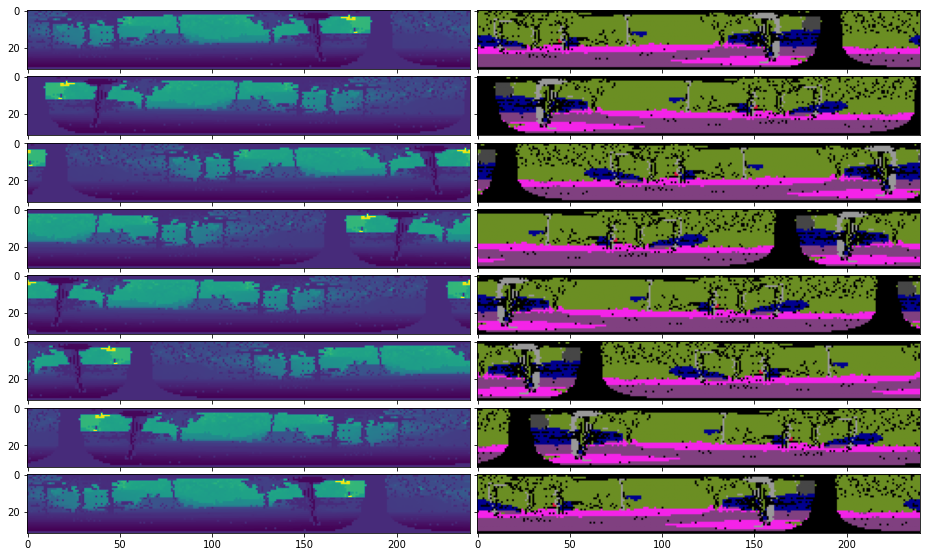

In [13]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(8, 2),
                 axes_pad=0.1,
                 )

for i in range(0, 8*2, 2):
    lidar, mask, label = parse_sample(tf.constant(train_pathes[0]))
    rgb_encoding = segmentation_map_to_rgb_encoding(label, cfg.CLS_COLOR_MAP)
    
    grid[i].imshow(lidar[:, :, 0])
    grid[i+1].imshow(rgb_encoding)

### Expected Output

Great! We have now a sample parser with augmentation. You can see that the samples are have much more variation in terms of the horizontal positions which will incerase the robustness of the model.  

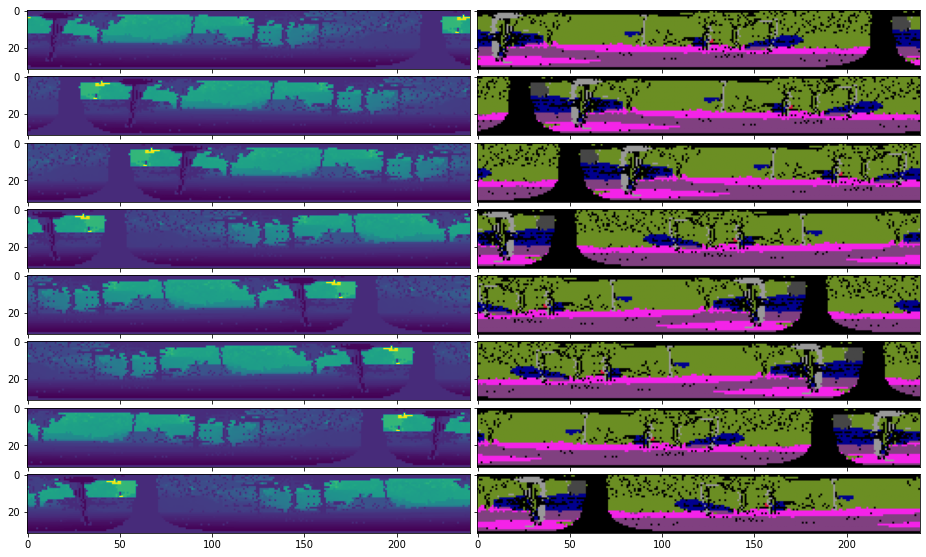


### Definition `fix_shape` helper funktion
We will now proceed with the creation of the input pipeline. We will now define the helper function `fix_shape` which you should have implemented in the previous assignment.

In [14]:
def fix_shape(lidar, mask, label, batch_size):
    """
    Sets the correct shape information for the input tensors and the label tensor.
    
    Arguments:
    lidar -- tf.Tensor containing the lidar input tensor. tf.shape information are not assigned
    mask -- tf.Tensor with the lidar mask tensor. tf.shape information are not assigned
    label -- tf.Tensor with the label tensor.  tf.shape information are not assigned
    
    Returns:
    (lidar, mask) -- Tuple of two tf.Tensors:
                     - lidar tf.Tensor with shape [batch_size, height, width, 6]
                     - mask tf.Tensor with shape [batch_size, height, width]
    label -- tf.Tensor with shape [batch size, height, width]
    """
    
    lidar.set_shape([batch_size, cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL, 6])
    mask.set_shape([batch_size,  cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL])
    label.set_shape([batch_size, cfg.ZENITH_LEVEL, cfg.AZIMUTH_LEVEL])
   
    return (lidar, mask), label

## Task: Create Dataset with optional augmentation

Now, we want to use the `parse_sample` function in our dataset pipeline. We will use almost the same function as in the previous assignment, but we want to make the augmentation optional. That's why we have the additional parameter `do_augmentation` that creates the `tf.data.Dataset` with or without the augmentation function.

#### Replace the `None` placeholders with your code

### Hints
- Recap from the previous assignment how to use a numpy function within Tensorflow. Use `tf.py_function()` and the `lambda` directive.
- Use `tf.data.AUTOTUNE` for all `.map()` calls.
- Make sure to use `parse_sample` for the case that `do_augmentation` is `True`
- Use the wrapper function `parse_sample_without_augmentation` which is defined below in the case when `do_augmentation` is `False`.

In [15]:
def parse_sample_without_augmentation(sample):
    return parse_sample(sample, do_augmentation=False)

In [16]:
def create_dataset(sample_pathes, batch_size, buffer_size=200, do_augmentation=True):
    """
    Arguments:
    sample pathes -- List of Strings which contain pathes for the training samples
    batch_size -- Integer which defines the number of samples per batch
    buffer_size -- Integer defines the size of the shuffle buffer
    do_augmentation -- Boolean which defines if the augmentation should be applied or not
    
    Returns:
    dataset -- tf.data.Dataset
    """
    
    # create a tf.data.Dataset using sample_pathes
    dataset = tf.data.Dataset.from_tensor_slices(sample_pathes)
    
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size)
    
    ### START CODE HERE ###
    
    if do_augmentation: # if None:
        # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
        dataset = dataset.map(lambda sample: tf.py_function(parse_sample, [sample], [tf.float32, tf.bool, tf.int32]),
                              tf.data.AUTOTUNE)
        
        # dataset = dataset.map(None)
    
    else:
        # Apply the parse_sample_without_augmentation function. Use tf.data.AUTOTUNE for the number of parallel calls
        dataset = dataset.map(lambda sample: tf.py_function(parse_sample_without_augmentation, [sample], [tf.float32, tf.bool, tf.int32]),
                              tf.data.AUTOTUNE)
        
        # dataset = dataset.map(None)
            
    ### END CODE HERE ###
    
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size) 
    
    # Fix the input shapes by applying the function fix_shape. 
    dataset = dataset.map(lambda lidar, mask, label: fix_shape(lidar, mask, label, batch_size),
                          tf.data.AUTOTUNE)
    
    # Use prefetching for better pipeline performance.
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

### Test `create_dataset`
Check the output of the following cell to check the implementation of `create_dataset`. Be aware that this test is not complete. It can only give you an indication if your implementation of above functions is correct.

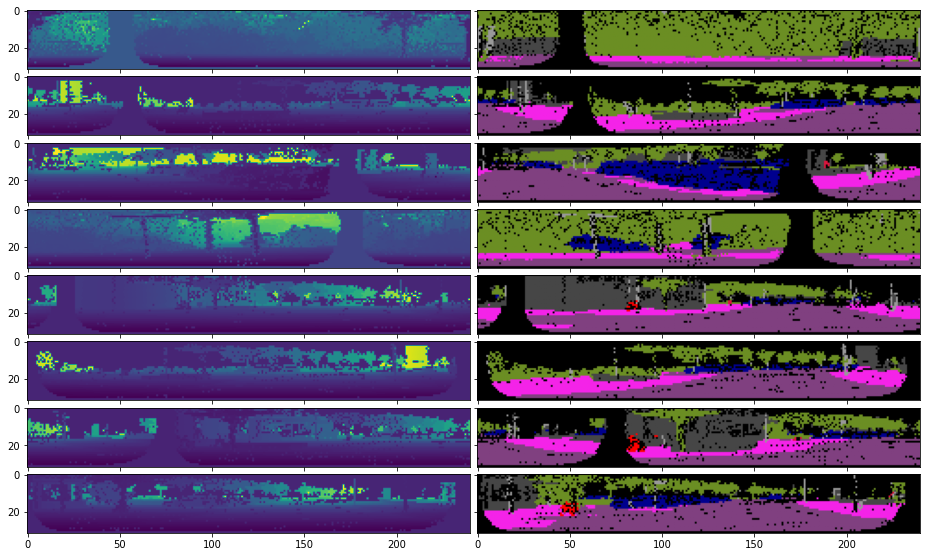

In [17]:
train = create_dataset(train_pathes, batch_size=4, do_augmentation=True)
val = create_dataset(val_pathes, batch_size=1, do_augmentation=False)


fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(8, 2),
                 axes_pad=0.1,
                 )

for i, sample in enumerate(train):
    lidar = sample[0][0].numpy()
    label = sample[1].numpy()
    
    # take only one sample from the batch
    lidar = lidar[0, :, :, :]
    label = label[0, :, :]
    
    rgb_encoding = segmentation_map_to_rgb_encoding(label, cfg.CLS_COLOR_MAP)
    
    j = i*2
    grid[j].imshow(lidar[:, :, 0])
    grid[j+1].imshow(rgb_encoding)
    
    if i > 6:
        break

### Expected Output

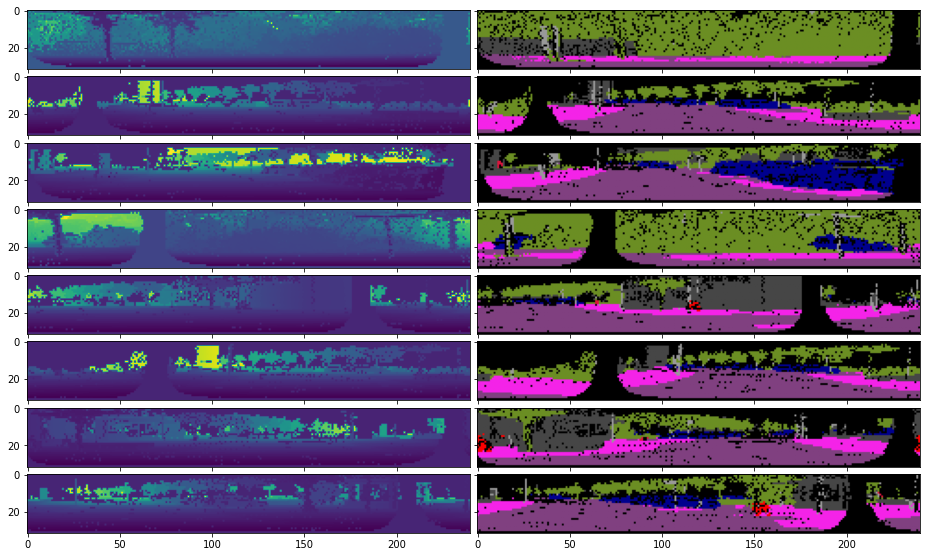

# Network and Training

We will use again the __SqueezeSegV2__ architecture from previous assignment. In this assignment we will implement a small improvement to the approach. From the semantic image segmentation assignment and the previous assignment you know that the loss function computes the error between label and model prediction. We used in both cases the normal Categorical Crossentropy loss. In particular we used `tf.keras.losses.SparseCategoricalCrossentropy()`.

As a recap: the Cross-Entropy loss is defined as
\begin{equation}
CE = - \sum^{C}_{i} t_i \log(p_i)
\end{equation}
with $t_i$ as the ground truth label (as one-hot encoding) and $p_i$ as the probability for each class $i$ in $C$.


Now let's have a look on the following picture. It shows us the relative class distribution in the training dataset. 

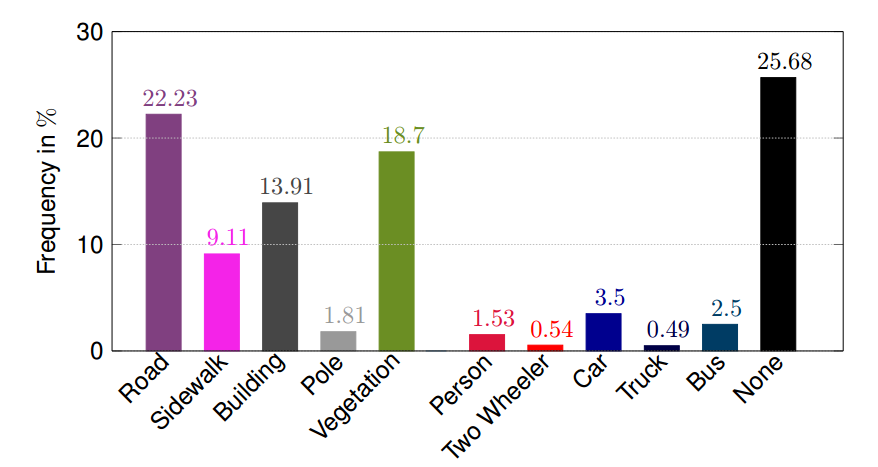

You can see that the dataset has a very high class imbalance. Classes with large surfaces such as __road__, __building__ and __vegetation__ are overrepresented. Other classes such as __person__, __two wheeler__ and __truck__ are underrepresented. The normal Categorical Crossentropy does not take this imbalance into consideration. Hence, less frequent classes might not have a great impact on the loss and may be overseen during training.

The authors of [SqueezeSegV2](https://arxiv.org/abs/1710.07368) recommend to use the __focal loss__ function instead. This function boosts underrepresented class instances by adding a modulating factor to the Cross-Entropy. Hence, it tackles the problem of class imbalance. The focal loss is defined as:


\begin{equation}
FL = - \sum^{C}_{i} (1-p_i)^{\gamma} (t_i \log(p_i))
\end{equation}
Where $\gamma$ is a tuneable factor that regulate the loss magnitude of instances with low probability. The probability of one instance (pixel) is again given by $p_i$. That means, instances with low probability $p_i$ obtain a higher weighting in the loss function and pixels with high probability have a lower weight. You can read more about Focal Loss in [this article](https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7).

Now we want to implement the __focal loss__ in Tensorflow.

# Task: Focal Loss

Implement the focal loss function.

#### Replace the `None` placeholders with your code


### Hints
- Use [tf.one_hot()](https://www.tensorflow.org/api_docs/python/tf/one_hot) to convert `label` into the one-hot representation. The `depth` of these one-hot encoding will be the numer of classes
- Use [tf.math.log()](https://www.tensorflow.org/api_docs/python/tf/math/log) to compute the $log()$ of the probabilities
- `**` is the operator for exponentiation
- Simply muliply the `weight` with `cross_entropy`
- Note all operations are vectorized there is no need to write any loops over the elements or classes

In [18]:
def focal_loss(probabilities, lidar_mask, label, num_class, focal_gamma, denom_epislon, clf_loss_coef=15):
    """
    Compute the focal loss for semantic segmentation
    
    """
    # Cast from bool to float32 for multiplication
    lidar_mask = tf.cast(lidar_mask, tf.float32) 
    
    # Reshape label to [heigh X width]
    label = tf.reshape(label, (-1,))  # class labels
    
    # Reshape the probablity to [height X width, num_classes]
    prob = tf.reshape(probabilities, (-1, num_class))   
    
    # Add small number to avoid division by zero
    prob = prob + denom_epislon
    
    ### START CODE HERE ###
    
    # Convert labels to onehot representation
    onehot_labels = tf.one_hot(label, depth=num_class)  # onehot_labels = None
    
    # Compute the Cross Entropy (without sum) by multiplying onehot_labels with the log(prob)
    cross_entropy = tf.multiply(onehot_labels, tf.math.log(prob)) # cross_entropy = tf.multiply(None, None)
    
    # Compute the modulating factor of the focal loss and apply focal_gamma as exponent
    weight = (1.0 - prob) ** focal_gamma  # weight = (None - None) ** None

    # Compute the focal loss by multiplying weight with the cross_entropy
    fl = weight * cross_entropy  # fl = None * None
    
    ### END CODE HERE ###
    
    # Do normalization with number of valid samples and multiply with a loss coefficient
    loss = - tf.reduce_sum(fl) / tf.reduce_sum(lidar_mask) * clf_loss_coef 

    return loss

## Test `focal_loss`

In [19]:
num_class = 12
focal_gamma = 2
denom_epislon = 0.000001
tf.random.set_seed(42)
prob = tf.random.uniform([32, 240, num_class], minval=0, maxval=1, dtype=tf.dtypes.float32)
mask = tf.random.uniform([32, 240], minval=0, maxval=2, dtype=tf.dtypes.int32)
label = tf.random.uniform([32, 240], minval=0, maxval=num_class, dtype=tf.dtypes.int32)

fl = focal_loss(prob, mask, label, num_class, focal_gamma, denom_epislon, clf_loss_coef=15)

print("Focal Loss: ", fl.numpy())

Focal Loss:  18.188799


### Expected Output
If the implementation is correct, you should see the following output

## Configs and Network architecture

In the following we setup some configurations and the model very similar to the previous assignment. Feel free to read about this architecture in the original paper [SqueezeSegV2](https://arxiv.org/abs/1809.08495).

In [20]:
# Network Parameter
cfg.L2_WEIGHT_DECAY = 0.05
cfg.DROP_RATE = 0.1
cfg.BN_MOMENTUM = 0.99
cfg.REDUCTION = 16

# Focal Loss Parameter
cfg.FOCAL_GAMMA = 2.0
cfg.DENOM_EPSILON = 1e-12   # small value used in denominator to prevent division by 0
cfg.CLS_LOSS_COEF = 15.0

In [21]:
from pcl_segmentation_utils import CAM, FIRE, FIREUP

Similar to the previous assignment, we will build the whole model architecture in the following cell. Again, we don't require you to implement any missing code snippets here, but notice that in this case the __focal loss__ function is implemented instead of the usual cross-entropy loss function.

Note that the __focal loss__ is called with
```python
loss = focal_loss(probabilities, lidar_mask, label, cfg.NUM_CLASS, cfg.FOCAL_GAMMA, cfg.DENOM_EPSILON, cfg.CLS_LOSS_COEF)
```

The focal gamma $\gamma$ is set to $2$.

Also note, that the loss is computed during the `train_step()` and the `test_step()`


In [22]:
class SqueezeSegV2(tf.keras.Model):
    """SqueezeSegV2 Model as custom Keras Model in TF 2.4"""

    def __init__(self, cfg):
        super(SqueezeSegV2, self).__init__()
        self.NUM_CLASS = cfg.NUM_CLASS
        self.CLASSES = cfg.CLASSES
        
        # input shape
        self.BATCH_SIZE = None
        self.ZENITH_LEVEL = cfg.ZENITH_LEVEL
        self.AZIMUTH_LEVEL = cfg.AZIMUTH_LEVEL
        self.NUM_FEATURES = cfg.NUM_FEATURES
        
        # regularization
        self.drop_rate = cfg.DROP_RATE
        self.l2 = cfg.L2_WEIGHT_DECAY
        self.bn_momentum = cfg.BN_MOMENTUM

        # Metrics
        self.miou_tracker = tf.keras.metrics.MeanIoU(num_classes=self.NUM_CLASS, name="MeanIoU")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

        # Layers
        
        # Encoder
        self.conv1 = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=3,
            strides=[1, 2],
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)
        self.cam1 = CAM(in_channels=64, bn_momentum=self.bn_momentum, l2=self.l2)

        self.conv1_skip = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=1,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1_skip = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)

        self.fire2 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam2 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire3 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam3 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire4 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire5 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire6 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire7 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire8 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire9 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)

        # Decoder
        self.fire10 = FIREUP(sq1x1_planes=64, ex1x1_planes=128, ex3x3_planes=128, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire11 = FIREUP(sq1x1_planes=32, ex1x1_planes=64, ex3x3_planes=64, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire12 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire13 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)

        self.conv14 = tf.keras.layers.Conv2D(
            filters=self.NUM_CLASS,
            kernel_size=3,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.dropout = tf.keras.layers.Dropout(self.drop_rate)
        
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    
    def call(self, inputs, training=False, mask=None):
        """
        Defines one forward pass of the network
        """
        lidar_input, lidar_mask = inputs[0], inputs[1]

        # Encoder
        x = tf.nn.relu(self.bn1(self.conv1(lidar_input)))

        cam1_output = self.cam1(x)

        conv1_skip = self.bn1_skip(self.conv1_skip(lidar_input))

        x = tf.nn.max_pool2d(cam1_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire2(x)
        x = self.cam2(x)
        x = self.fire3(x)
        cam3_output = self.cam3(x)

        x = tf.nn.max_pool2d(cam3_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire4(x)
        fire5_output = self.fire5(x)

        x = tf.nn.max_pool2d(fire5_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        fire9_output = self.fire9(x)

        # Decoder
        x = self.fire10(fire9_output)
        x = tf.add(x, fire5_output)
        x = self.fire11(x)
        x = tf.add(x, cam3_output)
        x = self.fire12(x)
        x = tf.add(x, cam1_output)
        x = self.fire13(x)
        x = tf.add(x, conv1_skip)

        x = self.dropout(x)

        logits = self.conv14(x)
        
        probabilities, predictions = self.segmentation_head(logits, lidar_mask)
        
        return probabilities, predictions

    
    def segmentation_head(self, logits, lidar_mask):
        """
        The final layer of the segmentation network which performs the final segmentation.
        """
        with tf.name_scope("segmentation_head") as scope:
            probabilities = self.softmax(logits)

            predictions = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

            # set predictions to the "None" class where no points are present
            predictions = tf.where(tf.squeeze(lidar_mask),
                                   predictions,
                                   tf.ones_like(predictions) * self.CLASSES.index("None")
                                   )
        return probabilities, predictions
    
    
    def train_step(self, data):
        """
        Performs one training step which is called during model.fit()
        """
        (lidar_input, lidar_mask), label = data

        with tf.GradientTape() as tape:
            probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass
            loss = focal_loss(probabilities, lidar_mask, label, 
                              cfg.NUM_CLASS, cfg.FOCAL_GAMMA, cfg.DENOM_EPSILON, cfg.CLS_LOSS_COEF)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update & Compute Metrics
        with tf.name_scope("metrics") as scope:
            self.loss_tracker.update_state(loss)
            self.miou_tracker.update_state(label, predictions)
            loss_result = self.loss_tracker.result()
            miou_result = self.miou_tracker.result()
        return {'loss': loss_result, 'miou': miou_result}
    
    
    def test_step(self, data):
        """
        Performs one test step which is called during model.evaluate() and during model.fit()
        """
        (lidar_input, lidar_mask), label = data

        probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass

        loss = focal_loss(probabilities, lidar_mask, label, 
                          cfg.NUM_CLASS, cfg.FOCAL_GAMMA, cfg.DENOM_EPSILON, cfg.CLS_LOSS_COEF)

        # Update Metrics
        self.loss_tracker.update_state(loss)
        self.miou_tracker.update_state(label, predictions)

        return {'loss': self.loss_tracker.result(), 'miou': self.miou_tracker.result()}

Now, we can create an instance of the `SqueezeSegV2()` class and compile it with the Adam Optimizer.

In [23]:
model = SqueezeSegV2(cfg)  
model.compile(optimizer=tf.keras.optimizers.Adam())

# Model Training
Nice! Everything is now ready for training! We can train the model by calling `mode.fit()`. As the model architecture was optimized for performance, the training might progress quite fast compared to the image segmentation model in the previous assignment. Run the following cell to train the model with the `train` dataset:

In [24]:
model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
50/50 [==============================] - 16s 264ms/step - loss: 21.4668 - miou: 0.1553 - val_loss: 14.4550 - val_miou: 0.1868
Epoch 2/10
50/50 [==============================] - 13s 256ms/step - loss: 11.6436 - miou: 0.2299 - val_loss: 10.8593 - val_miou: 0.2374
Epoch 3/10
50/50 [==============================] - 13s 258ms/step - loss: 9.3592 - miou: 0.2610 - val_loss: 9.5025 - val_miou: 0.2302
Epoch 4/10
50/50 [==============================] - 13s 256ms/step - loss: 7.4875 - miou: 0.2924 - val_loss: 7.7571 - val_miou: 0.2987
Epoch 5/10
50/50 [==============================] - 13s 257ms/step - loss: 6.6066 - miou: 0.3374 - val_loss: 9.5772 - val_miou: 0.2586
Epoch 6/10
50/50 [==============================] - 13s 256ms/step - loss: 5.9169 - miou: 0.3450 - val_loss: 8.8980 - val_miou: 0.2885
Epoch 7/10
50/50 [==============================] - 13s 257ms/step - loss: 5.6937 - miou: 0.3561 - val_loss: 7.1419 - val_miou: 0.3079
Epoch 8/10
50/50 [==============================] -

### Expected Output
You can expect an output similar to the following

Great! You can see that the loss is decreasing and the MIoU is increasing. That means our model is set up correctly and the training is running smoothly.

# Evaluate the model

We train here our model only for 10 steps, due to the constrained resources on this server. As we do not want you to wait several hours to finish this assigment, we have already trained the same model with the augmentation pipeline for serveral hundreds steps for you. One model was trained __with training__ the other one __without__. Let's compare both models by evaluating them. 

### Model with augmentation
Evaluate the model that was trained with augmentation using the `evaluate()` class function and the `val` dataset

In [25]:
model.load_weights("pcl_pretrained_model_with_augmentation/model")

model.evaluate(val)

50/50 [==============================] - 1s 16ms/step - loss: 6.9376 - miou: 0.4392


[6.937593460083008, 0.40400612354278564]

### Expected Output

### Model without augmentation
Evaluate the model that was trained without augmentation using the `evaluate()` class function and the `val` dataset

In [26]:
model.load_weights("pcl_pretrained_model/model")

model.evaluate(val)

50/50 [==============================] - 1s 16ms/step - loss: 5.8413 - miou: 0.3478


[5.841282844543457, 0.3437952697277069]

### Expected Output

So you can see that we could again increase the model performance by adding some augmentation methods to the dataset and by using an adapted loss function. Note that the datasets in this assignment are still quite small. Ideally, the dataset would be much bigger and the effect of the loss function and the augmentation should also increase.  

Gratulations! You finished the Assignment `Boosting Semantic Point Cloud Segmentation`!

# Wrap Up
- You learned about __augmentation methods__ for LiDAR point clouds in the context of semantic image segmentation
- You learned about the __focal loss__ function
- You learned about comparing __different models__

# References

## License


MIT License

Copyright 2022 Institute for Automotive Engineering of RWTH Aachen University.